In [1]:
from collections import defaultdict
from itertools import product
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import heapq
import random

class Tarea:
    def __init__(self, tipo, duracion):
        self._tipo = tipo
        self._duracion = duracion

class Maquina:
    def __init__(self, tipo):
        self._tipo = tipo
        self._tareas = set()
        self._tiempo_ocupada = 0

    # pre: la tarea a realizar es del mismo tipo que la maquina
    # post: se han añadido la tarea a la máquina
    def add_tarea(self, tarea):
        self._tareas.add(tarea)
        self._tiempo_ocupada += tarea._duracion

class Demanda:
    # tareas: lista con tareas
    def __init__(self, tareas):
        # clave: tipo de tarea, valor: lista de tareas
        self._demanda = defaultdict(list)
        for tarea in tareas:
            self._demanda[tarea._tipo].append(tarea)
            
class Estado:
    def __init__(self, tareas_restantes, maquinas, m, g, min=None):
        self.tareas_restantes = tareas_restantes  # {'a': [tareas], 'b': [tareas], ...}
        self.maquinas = maquinas  # {'a': [maquina1, maquina2, ...], 'b': ...}
        self.m = m
        self.g = g  # costo acumulado hasta este estado
        
        if min is None:
            self.min = float('inf')
        else:
            self.min = min

    # Comparación de estados para la cola de prioridad
    def __lt__(self, other):
        return (self.g + self.h()) < (other.g + other.h())

    # Heurística
    def h(self):
        max_t = self.g
        min_t = self.min
        T_i = sum(tarea._duracion for tarea in self.tareas_restantes)
        h_i = (T_i - max_t + min_t) / self.m
        return max(0, h_i)

    # Heurística
    def h2(self):
        T_i = sum(tarea._duracion for tarea in self.tareas_restantes)
        max_t = max(self.costo_acumulado_maquinas.values())
        suma_tiempos_ocupados = sum(max_t - t for t in self.costo_acumulado_maquinas.values())

        h2_value = (T_i - suma_tiempos_ocupados) / self.m
        return max(0, h2_value)


class Fabrica:
    def __init__(self, maquinas):
        self._maquinas = defaultdict(list)

        for maquina in maquinas:
            self._maquinas[maquina._tipo].append(maquina)
            
    def asignacion_to_maquinas(self, asignacion, demanda, maquinas):
        for tarea_index, maquina in enumerate(asignacion):
            maquinas[maquina].add_tarea(demanda[tarea_index])


    def calcular_tiempo_total(self, asignacion, tareas):
        tiempo_por_maquina = {i: 0 for i in range(max(asignacion) + 1)}  # Crear dict por máquinas
        for tarea_index, maquina in enumerate(asignacion):
            tiempo_por_maquina[maquina] += tareas[tarea_index]._duracion

        # El costo es el máximo de los tiempos por máquina
        return max(tiempo_por_maquina.values()), min(tiempo_por_maquina.values())

    def asignacion_optima(self, demanda, maquinas):
        mejor_costo = float('inf')
        mejor_asignacion = None

        # Generar todas las combinaciones posibles de asignación 
        for asignacion in product(range(len(maquinas)), repeat=len(demanda)):

            # Calcular el tiempo total para esta asignación
            tiempo_total, _ = self.calcular_tiempo_total(asignacion, demanda)
            # Guardar la asignación si tiene un tiempo total menor al mejor encontrado
            if tiempo_total < mejor_costo:
                mejor_costo = tiempo_total
                mejor_asignacion = asignacion

        self.asignacion_to_maquinas(mejor_asignacion, demanda, maquinas)
        #for tarea_index, maquina in enumerate(mejor_asignacion):
        #    maquinas[maquina].add_tarea(demanda[tarea_index])  # Añadir tarea a la máquina correspondiente

        return mejor_costo, maquinas

    def fuerza_bruta(self, demanda):
        mejor_costo = -float('inf')
        nodos_expandidos = 0

        for tipo in self._maquinas:
            nodos_expandidos += len(demanda._demanda[tipo])**len(self._maquinas[tipo])
            costo_tipo, self._maquinas[tipo] = self.asignacion_optima(list(demanda._demanda[tipo]), self._maquinas[tipo])
            mejor_costo = max(mejor_costo, costo_tipo)

        return mejor_costo, self._maquinas, nodos_expandidos

    def astar_subtipo(self, demanda, maquinas):
        nodos_expandidos = 0
        estado_inicial = Estado(demanda, (), m=len(maquinas), g=0)
        open_set = []
        closed_set = set()
        heapq.heappush(open_set, estado_inicial)

        while open_set:
            estado_actual = heapq.heappop(open_set)
            if not estado_actual.tareas_restantes: # es_meta ?
                # Añadir tarea a la máquina correspondiente
                self.asignacion_to_maquinas(estado_actual.maquinas, demanda, maquinas)
                return estado_actual.g, maquinas, nodos_expandidos

            for tarea in estado_actual.tareas_restantes:
                tareas = estado_actual.tareas_restantes[1:]

                for i in range(len(maquinas)):
                    nueva_combinacion = estado_actual.maquinas + (i,)
                    tiempo_total, min_aux = self.calcular_tiempo_total(nueva_combinacion, demanda)
                    
                    nuevo_estado = Estado(tareas, nueva_combinacion, m=len(maquinas), g = tiempo_total, min=min(estado_actual.min, min_aux))
                    estado_clave = (nuevo_estado.g, nueva_combinacion)

                    # Comprobar si el estado ya fue visitado
                    if estado_clave not in closed_set:
                        closed_set.add(estado_clave)
                        nodos_expandidos += 1
                        heapq.heappush(open_set, nuevo_estado)


    def astar(self, demanda):
        nodos_expandidos = 0
        mejor_costo = -float('inf')
        for tipo in self._maquinas:
            costo_tipo, self._maquinas[tipo], nodos = self.astar_subtipo(list(demanda._demanda[tipo]), self._maquinas[tipo])
            mejor_costo = max(mejor_costo, costo_tipo)
            nodos_expandidos += nodos

        return mejor_costo, self._maquinas, nodos_expandidos
    
    
    def montecarlo(self, demanda):
        nodos_expandidos = 0
        mejor_costo = -float('inf')
        for tipo in self._maquinas:
            lista_demanda = list(demanda._demanda[tipo])
            asignacion_tipo = tuple(random.randint(0, len(self._maquinas[tipo])-1) for _ in range(len(lista_demanda)))
            self.asignacion_to_maquinas(asignacion_tipo, lista_demanda, self._maquinas[tipo])
            costo_tipo, _ = self.calcular_tiempo_total(asignacion_tipo, lista_demanda)
            mejor_costo = max(mejor_costo, costo_tipo)
            nodos_expandidos += 1

        return mejor_costo, self._maquinas, nodos_expandidos

    def monotone_beam_search_subtipo(self, demanda, maquinas):
        nodos_expandidos = 0
        estado_inicial = Estado(demanda, (), m=len(maquinas), g=0)
        open_set = []
        closed_set = set()
        heapq.heappush(open_set, estado_inicial)

        while open_set:
            estado_actual = heapq.heappop(open_set)

            # Verificar si hemos alcanzado el objetivo
            if not estado_actual.tareas_restantes:  # es_meta
                # Asignar tareas a las máquinas
                self.asignacion_to_maquinas(estado_actual.maquinas, demanda, maquinas)
                return estado_actual.g, maquinas, nodos_expandidos

            # Generar sucesores
            
            for tarea in estado_actual.tareas_restantes:
                tareas = estado_actual.tareas_restantes[1:]
                sucesores = []
                for i in range(len(maquinas)):
                    nueva_combinacion = estado_actual.maquinas + (i,)
                    tiempo_total, min_aux = self.calcular_tiempo_total(nueva_combinacion, demanda)

                    nuevo_estado = Estado(tareas, nueva_combinacion, m=len(maquinas), g=tiempo_total, min=min(estado_actual.min, min_aux))
                    estado_clave = (nuevo_estado.g, nueva_combinacion)

                    # Añadir sucesores nuevos no visitados a la lista
                    if estado_clave not in closed_set:
                        closed_set.add(estado_clave)
                        nodos_expandidos += 1
                        sucesores.append(nuevo_estado)

                # Seleccionar los `beam_size` sucesores con menor costo
                beam_size = len(sucesores) // 2 + 1  # Define el tamaño del haz
                mejores_sucesores = heapq.nsmallest(beam_size, sucesores, key=lambda x: x.g)
                open_set.extend(mejores_sucesores)


    def monotone_beam_search(self, demanda):
        nodos_expandidos = 0
        mejor_costo = -float('inf')
        for tipo in self._maquinas:
            costo_tipo, self._maquinas[tipo], nodos = self.monotone_beam_search_subtipo(list(demanda._demanda[tipo]), self._maquinas[tipo])
            
            mejor_costo = max(mejor_costo, costo_tipo)
            nodos_expandidos += nodos

        return mejor_costo, self._maquinas, nodos_expandidos

class Estado2:
    def __init__(self, tareas_restantes, maquinas, m, g, peso, min=None):
        self.tareas_restantes = tareas_restantes  # {'a': [tareas], 'b': [tareas], ...}
        self.maquinas = maquinas  # {'a': [maquina1, maquina2, ...], 'b': ...}
        self.m = m
        self.g = g  # costo acumulado hasta este estado
        self.peso = peso
        if min is None:
            self.min = float('inf')
        else:
            self.min = min

    # Comparación de estados para la cola de prioridad
    def __lt__(self, other):
        return (self.g + self.peso*self.h()) < (other.g + self.peso*other.h())

    # Heurística
    def h(self):
        max_t = self.g
        min_t = self.min
        T_i = sum(tarea._duracion for tarea in self.tareas_restantes)
        h_i = (T_i - max_t + min_t) / self.m
        return max(0, h_i)

    # Heurística
    def h2(self):
        T_i = sum(tarea._duracion for tarea in self.tareas_restantes)
        max_t = self.g
        
        tiempo_por_maquina = {i: 0 for i in range(max(self.maquinas) + 1)}  # Crear dict por máquinas
        for tarea_index, maquina in enumerate(self.maquinas):
            tiempo_por_maquina[maquina] += tareas[tarea_index]._duracion
    
        suma_tiempos_ocupados = sum(max_t - t for t in tiempo_por_maquina.values())

        h2_value = (T_i - suma_tiempos_ocupados) / self.m
        return max(0, h2_value)
    

class Fabrica2:
    def __init__(self, maquinas, peso):
        self._maquinas = defaultdict(list)
        self.peso = peso

        for maquina in maquinas:
            self._maquinas[maquina._tipo].append(maquina)
            
    def calcular_tiempo_total(self, asignacion, tareas):
        tiempo_por_maquina = {i: 0 for i in range(max(asignacion) + 1)}  # Crear dict por máquinas
        for tarea_index, maquina in enumerate(asignacion):
            tiempo_por_maquina[maquina] += tareas[tarea_index]._duracion

        # El costo es el máximo de los tiempos por máquina
        return max(tiempo_por_maquina.values()), min(tiempo_por_maquina.values())

    def astar_subtipo(self, demanda, maquinas):
        nodos_expandidos = 0
        estado_inicial = Estado2(demanda, (), m=len(maquinas), g=0, peso=self.peso)
        open_set = []
        closed_set = set()
        heapq.heappush(open_set, estado_inicial)

        while open_set:
            estado_actual = heapq.heappop(open_set)
            if not estado_actual.tareas_restantes: # es_meta
                for tarea_index, maquina in enumerate(estado_actual.maquinas):
                    maquinas[maquina].add_tarea(demanda[tarea_index])  # Añadir tarea a la máquina correspondiente

                return estado_actual.g, maquinas, nodos_expandidos

            for tarea in estado_actual.tareas_restantes:
                tareas = estado_actual.tareas_restantes[1:]

                for i in range(len(maquinas)):
                    nueva_combinacion = estado_actual.maquinas + (i,)
                    tiempo_total, min_aux = self.calcular_tiempo_total(nueva_combinacion, demanda)
                    
                    nuevo_estado = Estado2(tareas, nueva_combinacion, m=len(maquinas), g = tiempo_total, min=min(estado_actual.min, min_aux), peso=self.peso)
                    estado_clave = (nuevo_estado.g, nueva_combinacion)

                    # Comprobar si el estado ya fue visitado
                    if estado_clave not in closed_set:
                        closed_set.add(estado_clave)
                        nodos_expandidos += 1
                        heapq.heappush(open_set, nuevo_estado)


    def astar(self, demanda):
        nodos_expandidos = 0
        mejor_costo = 0
        first_time = True
        for tipo in self._maquinas:
            costo_tipo, self._maquinas[tipo], nodos = self.astar_subtipo(list(demanda._demanda[tipo]), self._maquinas[tipo])
            if first_time:
                mejor_costo = costo_tipo
                first_time = False
            else:
                mejor_costo = max(mejor_costo, costo_tipo)
            nodos_expandidos += nodos

        return mejor_costo, self._maquinas, nodos_expandidos

class Estado3:
    def __init__(self, tareas_restantes, maquinas, m, g, min=None):
        self.tareas_restantes = tareas_restantes  # {'a': [tareas], 'b': [tareas], ...}
        self.maquinas = maquinas  # {'a': [maquina1, maquina2, ...], 'b': ...}
        self.m = m
        self.g = g  # costo acumulado hasta este estado
        if min is None:
            self.min = float('inf')
        else:
            self.min = min

    # Comparación de estados para la cola de prioridad
    def __lt__(self, other):
        return (self.g + self.h2()) < (other.g + other.h2())

    # Heurística
    def h2(self):
        T_i = sum(tarea._duracion for tarea in self.tareas_restantes)
        max_t = self.g
        
        tiempo_por_maquina = {i: 0 for i in range(max(self.maquinas) + 1)}  # Crear dict por máquinas
        for tarea_index, maquina in enumerate(self.maquinas):
            tiempo_por_maquina[maquina] += tareas[tarea_index]._duracion
    
        suma_tiempos_ocupados = sum(max_t - t for t in tiempo_por_maquina.values())

        h2_value = (T_i - suma_tiempos_ocupados) / self.m
        return max(0, h2_value)
    

class Fabrica3:
    def __init__(self, maquinas):
        self._maquinas = defaultdict(list)

        for maquina in maquinas:
            self._maquinas[maquina._tipo].append(maquina)
            
    def calcular_tiempo_total(self, asignacion, tareas):
        tiempo_por_maquina = {i: 0 for i in range(max(asignacion) + 1)}  # Crear dict por máquinas
        for tarea_index, maquina in enumerate(asignacion):
            tiempo_por_maquina[maquina] += tareas[tarea_index]._duracion

        # El costo es el máximo de los tiempos por máquina
        return max(tiempo_por_maquina.values()), min(tiempo_por_maquina.values())

    def astar_subtipo(self, demanda, maquinas):
        nodos_expandidos = 0
        estado_inicial = Estado3(demanda, (), m=len(maquinas), g=0)
        open_set = []
        closed_set = set()
        heapq.heappush(open_set, estado_inicial)

        while open_set:
            estado_actual = heapq.heappop(open_set)
            if not estado_actual.tareas_restantes: # es_meta
                for tarea_index, maquina in enumerate(estado_actual.maquinas):
                    maquinas[maquina].add_tarea(demanda[tarea_index])  # Añadir tarea a la máquina correspondiente

                return estado_actual.g, maquinas, nodos_expandidos

            for tarea in estado_actual.tareas_restantes:
                tareas = estado_actual.tareas_restantes[1:]

                for i in range(len(maquinas)):
                    nueva_combinacion = estado_actual.maquinas + (i,)
                    tiempo_total, min_aux = self.calcular_tiempo_total(nueva_combinacion, demanda)
                    
                    nuevo_estado = Estado3(tareas, nueva_combinacion, m=len(maquinas), g = tiempo_total, min=min(estado_actual.min, min_aux))
                    estado_clave = (nuevo_estado.g, nueva_combinacion)

                    # Comprobar si el estado ya fue visitado
                    if estado_clave not in closed_set:
                        closed_set.add(estado_clave)
                        nodos_expandidos += 1
                        heapq.heappush(open_set, nuevo_estado)

    def astar(self, demanda):
        nodos_expandidos = 0
        mejor_costo = 0
        first_time = True
        for tipo in self._maquinas:
            costo_tipo, self._maquinas[tipo], nodos = self.astar_subtipo(list(demanda._demanda[tipo]), self._maquinas[tipo])
            if first_time:
                mejor_costo = costo_tipo
                first_time = False
            else:
                mejor_costo = max(mejor_costo, costo_tipo)
            nodos_expandidos += nodos

        return mejor_costo, self._maquinas, nodos_expandidos
    

# Creamos algunas tareas
tareas = [Tarea('a', 5), Tarea('a', 3), Tarea('a', 7), Tarea('a', 6), Tarea('a', 5), Tarea('a', 3), Tarea('a', 7), Tarea('a', 6),
          Tarea('b', 8), Tarea('b', 9), Tarea('b', 11), Tarea('b', 2), Tarea('b', 8), Tarea('b', 9), Tarea('b', 11), Tarea('b', 2), 
          Tarea('c', 3), Tarea('c', 7), Tarea('c', 4), Tarea('c', 2), Tarea('c', 3), Tarea('c', 7), Tarea('c', 4), Tarea('c', 2),
          Tarea('d', 10), Tarea('d', 5), Tarea('d', 3), Tarea('d', 1), Tarea('d', 10), Tarea('d', 5), Tarea('d', 3), Tarea('d', 1)]
tareas1 = copy.deepcopy(tareas)
tareas2 = copy.deepcopy(tareas)
tareas3 = copy.deepcopy(tareas)
# Creamos algunas máquinas
maquinas = [Maquina('a'), Maquina('a'), Maquina('a'), Maquina('b'), Maquina('b'), Maquina('b'), Maquina('c'), Maquina('c'),Maquina('c'), Maquina('d'), Maquina('d'), Maquina('d')]
maquinas1 = copy.deepcopy(maquinas)
maquinas2 = copy.deepcopy(maquinas)
maquinas3 = copy.deepcopy(maquinas)

demanda = Demanda(tareas) # Creamos una demanda
fabrica = Fabrica(maquinas) # Creamos la fábrica


# Ejecutamos el algoritmo fuerza bruta
print(f"Algoritmo fuerza bruta*")
inicio = time.time()
resultado, maquinas, _ = fabrica.fuerza_bruta(demanda)
fin = time.time()
print(f"Tiempo de ejecución: {fin - inicio} segundos")
print("Tiempo mínimo total:", resultado)

demanda = Demanda(tareas1)   # Creamos la demanda
fabrica = Fabrica(maquinas1) # Creamos la fábrica
# Ejecutamos el algoritmo A*
print(f"Algoritmo A*")
inicio = time.time()
resultado, maquinas, nodos_expandidos = fabrica.astar(demanda)
fin = time.time()
print(f"Tiempo de ejecución: {fin - inicio} segundos")
print("Tiempo mínimo total:", resultado)
print("Nodos expandidos:", nodos_expandidos)

demanda = Demanda(tareas2)   # Creamos la demanda
fabrica = Fabrica(maquinas2) # Creamos la fábrica
# Ejecutamos el algoritmo Montecarlo
print(f"Algoritmo Montecarlo*")
inicio = time.time()
resultado, maquinas, nodos_expandidos = fabrica.montecarlo(demanda)
fin = time.time()
print(f"Tiempo de ejecución: {fin - inicio} segundos")
print("Tiempo mínimo total:", resultado)
print("Nodos expandidos:", nodos_expandidos)


demanda = Demanda(tareas3)   # Creamos la demanda
fabrica = Fabrica2(maquinas3, peso=3) # Creamos la fábrica
# Ejecutamos el algoritmo Montecarlo
print(f"Algoritmo wA*")
inicio = time.time()
resultado, maquinas, nodos_expandidos = fabrica.astar(demanda)
fin = time.time()

print(f"Tiempo de ejecución: {fin - inicio} segundos")
print("Tiempo mínimo total:", resultado)
print("Nodos expandidos:", nodos_expandidos)
for tipo_maquina, lista_maquinas in maquinas.items():
    print(f"Tipo de máquina: {tipo_maquina}")
    for i, maquina in enumerate(lista_maquinas):
        print(f"  Máquina {i + 1}, Tiempo ocupada: {maquina._tiempo_ocupada}, Tareas:")
        for i, tarea in enumerate(maquina._tareas):
            print(f"    - Tarea {i+1} (Duración: {tarea._duracion})")

Algoritmo fuerza bruta*
Tiempo de ejecución: 0.4777209758758545 segundos
Tiempo mínimo total: 20
Algoritmo A*
Tiempo de ejecución: 0.0359039306640625 segundos
Tiempo mínimo total: 20
Nodos expandidos: 267
Algoritmo Montecarlo*
Tiempo de ejecución: 0.0009968280792236328 segundos
Tiempo mínimo total: 24
Nodos expandidos: 4
Algoritmo wA*
Tiempo de ejecución: 0.016954421997070312 segundos
Tiempo mínimo total: 22
Nodos expandidos: 144
Tipo de máquina: a
  Máquina 1, Tiempo ocupada: 16, Tareas:
    - Tarea 1 (Duración: 7)
    - Tarea 2 (Duración: 6)
    - Tarea 3 (Duración: 3)
  Máquina 2, Tiempo ocupada: 13, Tareas:
    - Tarea 1 (Duración: 5)
    - Tarea 2 (Duración: 3)
    - Tarea 3 (Duración: 5)
  Máquina 3, Tiempo ocupada: 13, Tareas:
    - Tarea 1 (Duración: 7)
    - Tarea 2 (Duración: 6)
Tipo de máquina: b
  Máquina 1, Tiempo ocupada: 22, Tareas:
    - Tarea 1 (Duración: 9)
    - Tarea 2 (Duración: 2)
    - Tarea 3 (Duración: 11)
  Máquina 2, Tiempo ocupada: 19, Tareas:
    - Tarea 1 

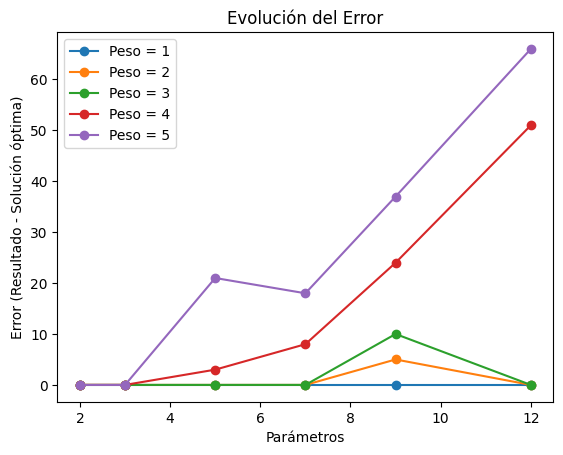

nodos espandidos: [52, 196, 476, 360, 1024, 2160]
nodos espandidos: [52, 128, 112, 136, 312, 320]
nodos espandidos: [52, 88, 104, 128, 260, 296]
nodos espandidos: [48, 84, 112, 184, 292, 424]
nodos espandidos: [44, 68, 120, 208, 324, 416]


In [14]:
# Experimento 0: eleccion del mejor parametro de wA*
def dataset(n):
    tasks = []
    tipos =  {0:'a', 1:'b', 2:'c', 3:'d'}
    for i in range(4):
        for j in range(n):
            tasks.append(Tarea(tipos[i], np.random.randint(5, 40)))
    return tasks

# Creamos algunas máquinas
maquinas = [Maquina('a'), Maquina('a'), Maquina('a'), Maquina('a'), 
            Maquina('b'), Maquina('b'), Maquina('b'), Maquina('b'),  
            Maquina('c'), Maquina('c'), Maquina('c'), Maquina('c'), 
            Maquina('d'), Maquina('d'), Maquina('d'), Maquina('d')]
    
tareas = [2, 3, 5, 7, 9, 12] 
parametros = [1, 2, 3, 4, 5]
tiemposA = {p: [] for p in parametros}  # Usamos un diccionario para almacenar tiempos por parámetro
resultados = {p: [] for p in parametros}  # Diccionario para almacenar resultados por parámetro
nodos_expandidos = {p: [] for p in parametros}  # Diccionario para nodos expandidos
errores = {p: [] for p in parametros}  # Diccionario para nodos expandidos

resultado_peso_1_dict = {}

# Mide el tiempo de ejecución para cada valor de parametro
for p in tareas:
    resultado_peso_1 = None
    
    tareas_dataset = dataset(p)
    for peso in parametros:
        maquinas1 = copy.deepcopy(maquinas)
        fabrica = Fabrica2(maquinas1, peso=peso)     # Creamos la fábrica
        tareas1 = copy.deepcopy(tareas_dataset)
        demanda = Demanda(tareas1)       # Creamos la demanda
    
        inicio = time.time()           
        resultado,_, nodos_exp = fabrica.astar(demanda)
        fin = time.time()              
        tiemposA[peso].append(fin - inicio)
        nodos_expandidos[peso].append(nodos_exp)
        resultados[peso].append(resultado)
        if peso == 1:
            resultado_peso_1 = resultado

    for peso in parametros:
        if peso == 1:
            errores[peso].append(0)
        else:
            error = abs(resultados[peso][-1] - resultado_peso_1)
            errores[peso].append(error)

# Gráfica : Error
for peso in parametros:
    plt.plot(tareas, errores[peso], marker='o', label=f'Peso = {peso}')  # Traza para cada peso
plt.title('Evolución del Error')
plt.xlabel('Parámetros')
plt.legend()
plt.ylabel('Error (Resultado - Solución óptima)')
plt.show()  # Muestra las gráficas

for peso in parametros:
    print("nodos espandidos:", nodos_expandidos[peso])

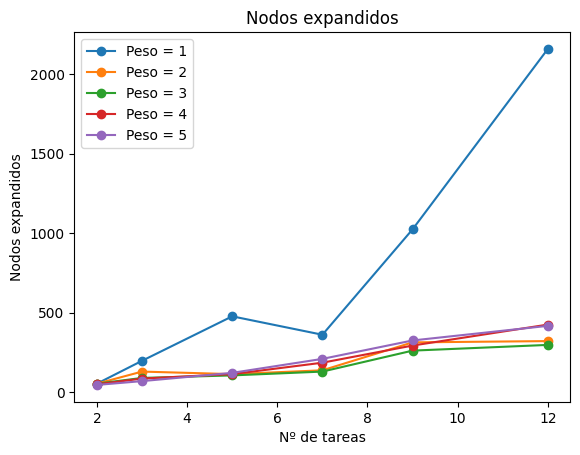

In [15]:
# Gráfica : Nodos expanidos
for peso in parametros:
    plt.plot(tareas, nodos_expandidos[peso], marker='o', label=f'Peso = {peso}')  # Traza para cada peso
plt.title('Nodos expandidos')
plt.xlabel('Nº de tareas')
plt.legend()
plt.ylabel('Nodos expandidos')
plt.show()  # Muestra las gráficas


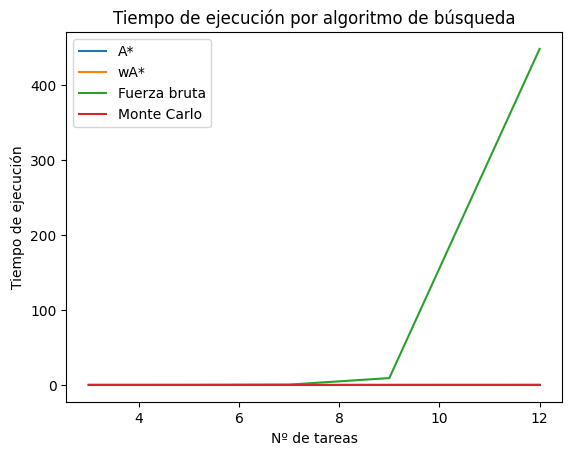

In [4]:
# Experimento 1: comparación algoritmos de busqueda (tiempos y nodos expandidos)

# Creamos algunas máquinas
maquinas = [Maquina('a'), Maquina('a'), Maquina('a'), Maquina('a'), 
            Maquina('b'), Maquina('b'), Maquina('b'), Maquina('b'),  
            Maquina('c'), Maquina('c'), Maquina('c'), Maquina('c'), 
            Maquina('d'), Maquina('d'), Maquina('d'), Maquina('d')]
    
tareas = [3, 5, 7, 9, 12] 
tiemposA, tiemposWA, tiemposFB, tiemposMC = [], [], [], []
nodos_expandidosA, nodos_expandidosWA, nodos_expandidosFB, nodos_expandidosMC = [], [], [], []

# Mide el tiempo de ejecución para cada valor de parametro
for p in tareas:
    maquinas1 = copy.deepcopy(maquinas)
    maquinas2 = copy.deepcopy(maquinas)
    maquinas3 = copy.deepcopy(maquinas)
    maquinas4 = copy.deepcopy(maquinas)

    fabrica1 = Fabrica(maquinas1)     # Creamos la fábrica
    fabrica2 = Fabrica2(maquinas2, peso=2)     # Creamos la fábrica
    fabrica3 = Fabrica(maquinas3)     # Creamos la fábrica
    fabrica4 = Fabrica(maquinas4)     # Creamos la fábrica

    tareas_dataset = dataset(p)
    tareas1 = copy.deepcopy(tareas_dataset)
    tareas2 = copy.deepcopy(tareas_dataset)
    tareas3 = copy.deepcopy(tareas_dataset)
    tareas4 = copy.deepcopy(tareas_dataset)

    demanda1 = Demanda(tareas1)       # Creamos la demanda
    demanda2 = Demanda(tareas2)       # Creamos la demanda
    demanda3 = Demanda(tareas3)       # Creamos la demanda
    demanda4 = Demanda(tareas4)       # Creamos la demanda

    inicio = time.time()           
    _, _, nodos_exp = fabrica1.astar(demanda1)
    fin = time.time()   

    tiemposA.append(fin - inicio)
    nodos_expandidosA.append(nodos_exp)
    
    inicio = time.time()           
    _, _, nodos_exp = fabrica2.astar(demanda2)
    fin = time.time()

    tiemposWA.append(fin - inicio)
    nodos_expandidosWA.append(nodos_exp)

    inicio = time.time()           
    _, _, nodos_exp = fabrica3.fuerza_bruta(demanda3)
    fin = time.time()

    tiemposFB.append(fin - inicio)
    nodos_expandidosFB.append(nodos_exp)

    inicio = time.time()           
    _, _, nodos_exp = fabrica4.montecarlo(demanda4)
    fin = time.time()

    tiemposMC.append(fin - inicio)
    nodos_expandidosMC.append(nodos_exp)


# Gráfica : tiempo de ejecución
plt.plot(tareas, tiemposA, label=f'A*')  # Traza para cada peso
plt.plot(tareas, tiemposWA, label=f'wA*')  # Traza para cada peso
plt.plot(tareas, tiemposFB, label=f'Fuerza bruta')  # Traza para cada peso
plt.plot(tareas, tiemposMC, label=f'Monte Carlo')  # Traza para cada peso

plt.title('Tiempo de ejecución por algoritmo de búsqueda')
plt.xlabel('Nº de tareas')
plt.legend()
plt.ylabel('Tiempo de ejecución')
plt.show()  # Muestra las gráficas


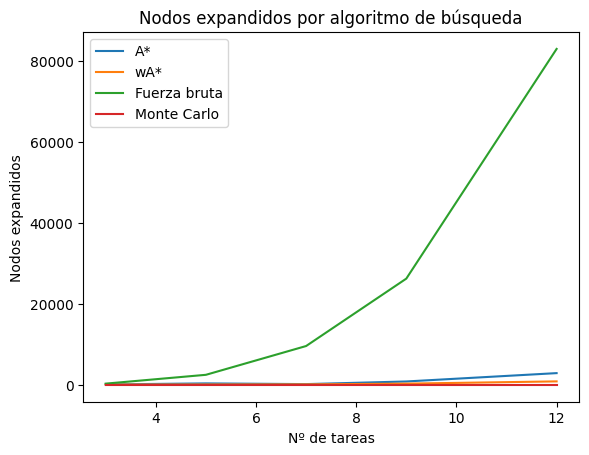

Nodos expandidos A*:  [120, 380, 204, 856, 2916]
Nodos expandidos WA*:  [84, 108, 136, 320, 876]
Nodos expandidos Fuerza Bruta:  [324, 2500, 9604, 26244, 82944]
Nodos expandidos Monte Carlo:  [4, 4, 4, 4, 4]


In [6]:

# Gráfica : nodos expandidos
plt.plot(tareas, nodos_expandidosA, label=f'A*')  # Traza para cada peso
plt.plot(tareas, nodos_expandidosWA, label=f'wA*')  # Traza para cada peso
plt.plot(tareas, nodos_expandidosFB, label=f'Fuerza bruta')  # Traza para cada peso
plt.plot(tareas, nodos_expandidosMC, label=f'Monte Carlo')  # Traza para cada peso

plt.title('Nodos expandidos por algoritmo de búsqueda')
plt.xlabel('Nº de tareas')
plt.legend()
plt.ylabel('Nodos expandidos')
plt.show()  # Muestra las gráficas

print('Nodos expandidos A*: ', nodos_expandidosA)
print('Nodos expandidos WA*: ', nodos_expandidosWA)
print('Nodos expandidos Fuerza Bruta: ', nodos_expandidosFB)
print('Nodos expandidos Monte Carlo: ', nodos_expandidosMC)



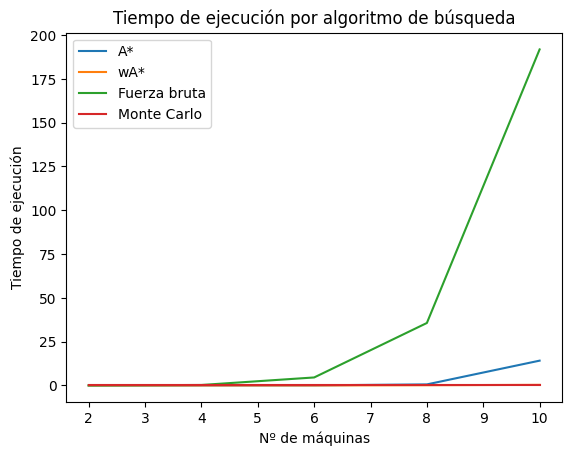

In [11]:
n_maquinas = [2, 4, 6, 8, 10] 
tiemposA, tiemposWA, tiemposFB, tiemposMC = [], [], [], []
nodos_expandidosA, nodos_expandidosWA, nodos_expandidosFB, nodos_expandidosMC = [], [], [], []

tareas_dataset = dataset(7)
# Mide el tiempo de ejecución para cada valor de parametro
for n in n_maquinas:
    maquinas = [Maquina(letra) for letra in 'abcd' for _ in range(n)]

    maquinas1 = copy.deepcopy(maquinas)
    maquinas2 = copy.deepcopy(maquinas)
    maquinas3 = copy.deepcopy(maquinas)
    maquinas4 = copy.deepcopy(maquinas)

    fabrica1 = Fabrica(maquinas1)     # Creamos la fábrica
    fabrica2 = Fabrica2(maquinas2, peso=2)     # Creamos la fábrica
    fabrica3 = Fabrica(maquinas3)     # Creamos la fábrica
    fabrica4 = Fabrica(maquinas4)     # Creamos la fábrica

    
    tareas1 = copy.deepcopy(tareas_dataset)
    tareas2 = copy.deepcopy(tareas_dataset)
    tareas3 = copy.deepcopy(tareas_dataset)
    tareas4 = copy.deepcopy(tareas_dataset)

    demanda1 = Demanda(tareas1)       # Creamos la demanda
    demanda2 = Demanda(tareas2)       # Creamos la demanda
    demanda3 = Demanda(tareas3)       # Creamos la demanda
    demanda4 = Demanda(tareas4)       # Creamos la demanda

    inicio = time.time()           
    _, _, nodos_exp = fabrica1.astar(demanda1)
    fin = time.time()   

    tiemposA.append(fin - inicio)
    nodos_expandidosA.append(nodos_exp)
    
    inicio = time.time()           
    _, _, nodos_exp = fabrica2.astar(demanda2)
    fin = time.time()

    tiemposWA.append(fin - inicio)
    nodos_expandidosWA.append(nodos_exp)

    inicio = time.time()           
    _, _, nodos_exp = fabrica3.fuerza_bruta(demanda3)
    fin = time.time()

    tiemposFB.append(fin - inicio)
    nodos_expandidosFB.append(nodos_exp)

    inicio = time.time()           
    _, _, nodos_exp = fabrica4.montecarlo(demanda4)
    fin = time.time()

    tiemposMC.append(fin - inicio)
    nodos_expandidosMC.append(nodos_exp)


# Gráfica : tiempo de ejecución
plt.plot(n_maquinas, tiemposA, label=f'A*')  # Traza para cada peso
plt.plot(n_maquinas, tiemposWA, label=f'wA*')  # Traza para cada peso
plt.plot(n_maquinas, tiemposFB, label=f'Fuerza bruta')  # Traza para cada peso
plt.plot(n_maquinas, tiemposMC, label=f'Monte Carlo')  # Traza para cada peso

plt.title('Tiempo de ejecución por algoritmo de búsqueda')
plt.xlabel('Nº de máquinas')
plt.legend()
plt.ylabel('Tiempo de ejecución')
plt.show()  # Muestra las gráficas


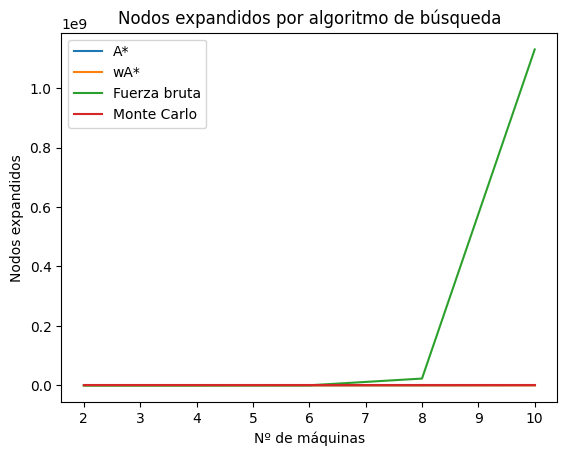

In [18]:
# Gráfica : nodos expandidos
plt.plot(n_maquinas, nodos_expandidosA, label=f'A*')  # Traza para cada peso
plt.plot(n_maquinas, nodos_expandidosWA, label=f'wA*')  # Traza para cada peso
plt.plot(n_maquinas, nodos_expandidosFB, label=f'Fuerza bruta')  # Traza para cada peso
plt.plot(n_maquinas, nodos_expandidosMC, label=f'Monte Carlo')  # Traza para cada peso

plt.title('Nodos expandidos por algoritmo de búsqueda')
plt.xlabel('Nº de máquinas')
plt.legend()
plt.ylabel('Nodos expandidos')
plt.show()  # Muestra las gráficas

In [17]:
print('nodos_expandidosA', nodos_expandidosA)
print('nodos_expandidosWA', nodos_expandidosWA)
print('nodos_expandidosFB', nodos_expandidosFB)
print('nodos_expandidosMC', nodos_expandidosMC)

nodos_expandidosA [232, 468, 1638, 16672, 516990]
nodos_expandidosWA [98, 140, 294, 3784, 11180]
nodos_expandidosFB [196, 9604, 470596, 23059204, 1129900996]
nodos_expandidosMC [4, 4, 4, 4, 4]


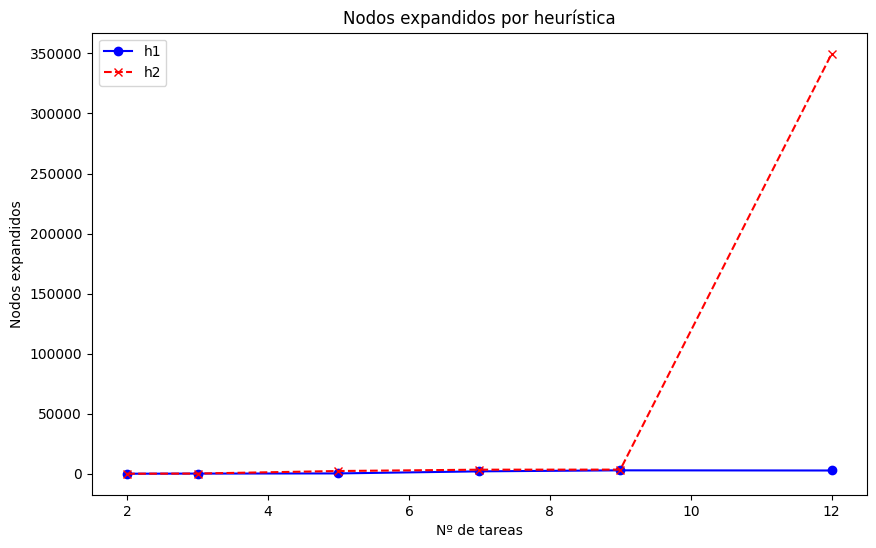

Nodos expandidos h1: [60, 160, 304, 2024, 2872, 2736]
Nodos expandidos h2: [52, 196, 2308, 3416, 3480, 349764]


In [4]:
parametros = [2,3,5,7,9,12]  # Cambia el rango según tus necesidades
tiemposh1, nodos1 = [], []
tiemposh2, nodos2 = [], []


# Mide el tiempo de ejecución para cada valor de parametro
for p in parametros:
    # Creamos algunas máquinas
    maquinas = [Maquina('a'), Maquina('a'), Maquina('a'), Maquina('a'), 
                Maquina('b'), Maquina('b'), Maquina('b'), Maquina('b'),  
                Maquina('c'), Maquina('c'), Maquina('c'), Maquina('c'), 
                Maquina('d'), Maquina('d'), Maquina('d'), Maquina('d')]
    
    maquinas1 = copy.deepcopy(maquinas)
    # Creamos la fábrica
    tareas = dataset(p)
    tareas1 = copy.deepcopy(tareas)

    fabrica = Fabrica(maquinas)     # Creamos la fábrica
    demanda = Demanda(tareas)       # Creamos la demanda
    
    inicio = time.time()           
    _, _, nodos_expandidos = fabrica.astar(demanda)
    fin = time.time()              
    tiemposh1.append(fin - inicio)    
    nodos1.append(nodos_expandidos)
    
    fabrica2 = Fabrica3(maquinas1)    # Creamos la fábrica
    demanda = Demanda(tareas1)       # Creamos la demanda
    
    inicio = time.time()           
    _, _, nodos_expandidos2 = fabrica2.astar(demanda)
    fin = time.time()             
    tiemposh2.append(fin - inicio)     
    nodos2.append(nodos_expandidos2)

plt.figure(figsize=(10, 6))
plt.plot(parametros, nodos1, marker='o', color='b', linestyle='-', label='h1')
plt.plot(parametros, nodos2, marker='x', color='r', linestyle='--', label='h2')
plt.xlabel('Nº de tareas')
plt.ylabel('Nodos expandidos')
plt.title('Nodos expandidos por heurística')
plt.legend()  # Muestra la leyenda
plt.show()

print("Nodos expandidos h1:", nodos1)
print("Nodos expandidos h2:", nodos2)


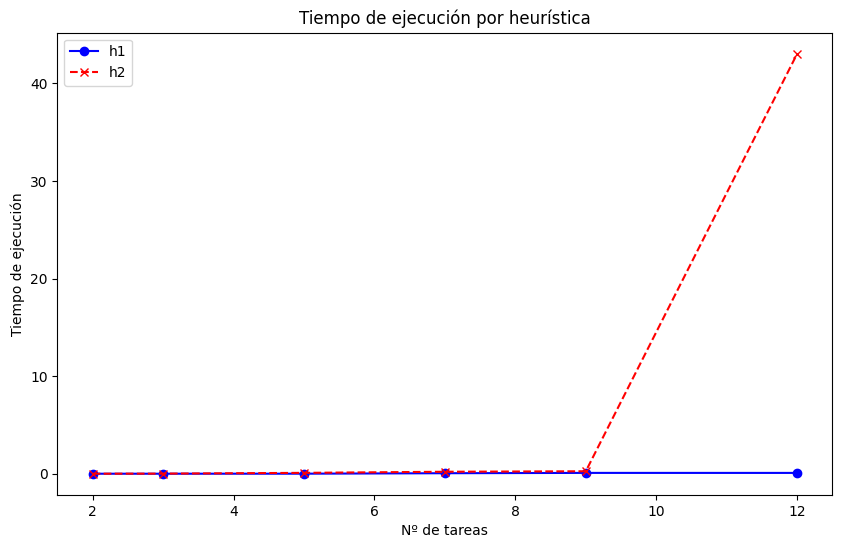

Tiempo de ejecución h1: [0.0010256767272949219, 0.0009822845458984375, 0.0049703121185302734, 0.05286407470703125, 0.08577466011047363, 0.08377575874328613]
Tiempo de ejecución h2: [0.0019698143005371094, 0.010970592498779297, 0.09075522422790527, 0.20352530479431152, 0.25331950187683105, 43.03495526313782]


In [5]:
plt.figure(figsize=(10, 6))
plt.plot(parametros, tiemposh1, marker='o', color='b', linestyle='-', label='h1')
plt.plot(parametros, tiemposh2, marker='x', color='r', linestyle='--', label='h2')
plt.xlabel('Nº de tareas')
plt.ylabel('Tiempo de ejecución')
plt.title('Tiempo de ejecución por heurística')
plt.legend()  # Muestra la leyenda
plt.show()

print("Tiempo de ejecución h1:", tiemposh1)
print("Tiempo de ejecución h2:", tiemposh2)